In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, label_name, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [7]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = np.array([self.y[idx]]).astype('float16')
        if self.transform is not None:
            image = self.transform(image)
        return [image, label]

In [8]:
def train(model, train_loader, optimizer):
    total_mae, total_mse = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.train()
    for inputs, labels in tqdm(train_loader):              
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        
        # feedforward
        outputs = model(inputs)
        
        pred = outputs.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
        # calculate loss
        mse = criterion1(outputs, labels)
        mae = criterion2(outputs, labels)
        
        # gradient initialization
        optimizer.zero_grad()
        # backpropagation
        mse.backward()
        # weight update
        optimizer.step()
        
        total_mae += mae.data.item()
        total_mse += mse.data.item()
        
        gc.collect()
        torch.cuda.empty_cache()
    return preds, truths, total_mse, total_mae

In [9]:
def valid(model, valid_loader):    
    total_mae, total_mse = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            outputs = model(inputs)
            
            pred = outputs.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            mse = criterion1(outputs, labels)
            mae = criterion2(outputs, labels)
            
            total_mae += mae.data.item()
            total_mse += mse.data.item()
        
    return preds, truths, total_mse, total_mae

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [11]:
label_name = 'FL_WMH_VOL_icv'
# label_name = 'FL_WMH_VOL_mL'
# label_name = 'WMH_GRADE'
# label_name = 'Cortical Gray Matter Total Percent Of Icv'
# label_name = 'FL_PVWMH_VOL_icv'
# label_name = 'FL_DWMH_VOL_icv'
img_dir = 'img_npy/'
label_dir = 'labels/data_975.csv'

In [12]:
# 이번 실험 고정 값
batch_size = 16
test_batch_size = 32
k = 5

In [13]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=True, norm=True)

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train set
train_set = NeckDataset(X_train, y_train)

# test set & loader
test_set = NeckDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

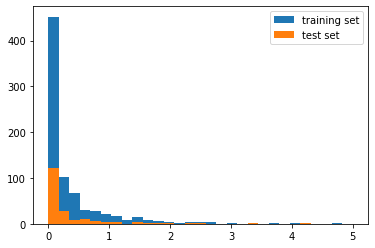

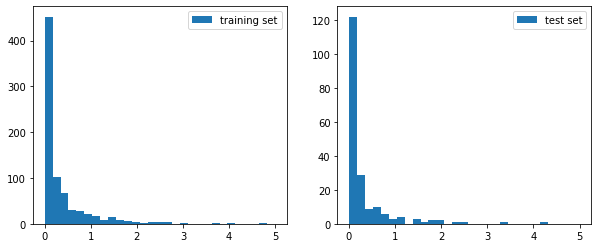

In [14]:
bins = np.linspace(0, 5, 30)

plt.hist(y_train, bins, label='training set')
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')
plt.show()
plt.close()


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_train, bins, label='training set')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')

plt.show()
plt.close()

In [15]:
class MLP(nn.Module):
    def __init__(self, d_in=1399440, d_out=1, h=[512,256,128,128,64,32], dropout_p=0.2):
        super().__init__()
        n_layer = len(h)  # number of layers
        self.layer = nn.Sequential()
        for i in range(n_layer):
            if i == 0:
                in_features = d_in
            else:
                in_features = h[i-1]
            out_features = h[i]
            self.layer.add_module('fc%d'%(i+1), nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU()))
    #             self.layer.add_module('linear_%d'%(i+1), nn.ReLU(nn.Linear(in_features, out_features)))
        self.dropout = nn.Dropout(dropout_p)
        self.fc_out = nn.Linear(out_features, d_out)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(self.layer(x))
        x = F.leaky_relu(self.fc_out(x))
#         x = self.fc_out(x)  # without leaky relu
        return x

In [16]:
mlp = MLP()
mlp

MLP(
  (layer): Sequential(
    (fc1): Sequential(
      (0): Linear(in_features=1399440, out_features=512, bias=True)
      (1): ReLU()
    )
    (fc2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
    )
    (fc3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (fc4): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (fc5): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (fc6): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc7): Linear(in_features=32, out_features=1, bias=True)
)

---

In [17]:
# 바꿀 값
epochs = 150
weight_decay = 0.01
lr = 1e-03
optim_class = optim.AdamW
dropout_rate = 0.2

In [18]:
# 5-Fold cross validation
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MLP(dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230309-MLP',
               config={"model": "MLP-1", "dropout": dropout_rate,
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.95it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.04it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.01it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 26 / 150


 23%|██████████▏                                 | 9/39 [00:09<00:31,  1.05s/it]


KeyboardInterrupt: 

---

In [19]:
# 바꿀 값
epochs = 150
weight_decay = 0.01
lr = 1e-03
optim_class = optim.AdamW
dropout_rate = 0.0

In [20]:
# 5-Fold cross validation
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MLP(dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230309-MLP',
               config={"model": "MLP-1", "dropout": dropout_rate,
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


train_mae,█▄▅▅▃▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_mse,█▃▅▄▃▄▃▃▃▃▃▃▃▂▂▂▁▁▁▂▁▁▁▁▁
train_pearson,▂▁▁▁▃▁▁▁▂▁▂▃▃▄▅▆▇▇▇▆▇████
train_spearman,▂▁▂▂▃▂▂▃▃▃▃▄▃▂▃▄▆▇▆▄▆▇███
valid_mae,▆▃█▂▂▄▂▂▃▃▂▂▂▂▁▁▂▁▁▁▂▁▂▁▂
valid_mse,▆▄█▃▃▄▃▃▃▃▃▃▃▁▂▂▁▁▂▁▁▁▁▁▁
valid_pearson,▆█▇▇▇▆▆█▆▇▇▂▃▄▁▆▆█▃▇▇▇█▇▇
valid_spearman,▆████▇▆█▇█▇▇█▆▁▆▅▇▆▇▆▇▇▇▇
train_mae,0.17633
train_mse,0.08224
train_pearson,0.8742


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.25it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.25it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.86it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:05<00:00,  2.38it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.25it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.95it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.98it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.98it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.99it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.18it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.04it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.95it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.95it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.97it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


train_mae,█▅▅▄▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
train_mse,█▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▁▁▄▇██████████████████████████████████▇
train_spearman,▁▁▃▃▅▇▇▇▇█▇▇▇▇█████▇▇▇█████████████████▆
valid_mae,█▇▃▄▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▃▁▂▂▁▂▂▂▂▂▁▂▂▂▄▂▅
valid_mse,█▇▅▄▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂
valid_pearson,▆▆▁▄▇▆▇▇▇▇█▇█▇▇▇▇▇▇█▅▇█▇█▆█▇▇▇▇▇▇█▇▇▇▇▇▅
valid_spearman,▅▅▁▅▆▆▅▅▆▆▆▅█▆▆▆▆▆▆▇▆▆▇▆▇▆▇▆▆▇▇▇▇▇▇▇▇▆█▄
train_mae,0.1669
train_mse,0.06973
train_pearson,0.90085


Fold 2


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.18it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.12it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.97it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.25it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.12it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.12it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.98it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.01it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.62it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


train_mae,█▄▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▃▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▂▂▁▂▇█████████████████████████████████
train_spearman,▁▁▂▁▂▂▅▆▆▇▇▇▇▇███████████▇▇█████████████
valid_mae,█▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_mse,█▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▇▇▇▇▁▆▆▆▆▇▇▇▇▇▇▇▇█▇██▇▇▇▇█▇█▇▇█▇▇▇▇▇▇▇▇▇
valid_spearman,▄▅▅▄▄▁▂▁▂▄▅▅▆▆▆▆▆█▆█▆▆▆▆▆▆▅█▇▆▇▇▇▇▅▇▅█▆▇
train_mae,0.01958
train_mse,0.0009
train_pearson,0.99842


Fold 3


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


train_mae,█▅▇▄▄▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▅█▄▄▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▂▁▂▁▁▁▆█████████████████████████████████
train_spearman,▁▁▁▁▂▁▄▆▇██▇███▇█████▇████████▇▇▇█▇▇█▇▇▇
valid_mae,██▇▂▂▃▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁
valid_mse,██▇▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▆▇█▇▇▆▁▆▇▇▇▆▆▇▇▅▇▇▇▇▇▇▅█▇▇▇▇▇▇▇▅▇▇▇▇▇▇█▇
valid_spearman,▅▆▇█▇▇▁▆▆▇▇▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇▅▆▇▇█▇▆██
train_mae,0.05476
train_mse,0.00813
train_pearson,0.98775


Fold 4


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


train_mae,█▅▅▆▄▅▄▄▂▂▂▁▁▁▁▁▁▁▂▂▂▁▁▁▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁
train_mse,█▄▄▅▄▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▂▁▂▁▃▄▇███████████████████████████████
train_spearman,▁▂▂▁▂▂▂▃▅▆▇▇▇▇▇▇▇▇▇▆▇▇▇█▇▇█████▇▇▇██████
valid_mae,█▄▂▆▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_mse,█▄▂▆▄▃▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
valid_pearson,▆▇▆▇▂▆▇▁▇██▇▇▇▇▇▇▇▇█████▇███████▇█▇▇▇▇▇▇
valid_spearman,▄▅▄▄▅▁▅▂▄▆▆▆▄▇▆▆▆▆▆▅▇▇█▇▄▇▇█▇▇▇▆▄█▇▇▇▇▇▇
train_mae,0.02189
train_mse,0.00162
train_pearson,0.99733


Fold 5


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


train_mae,█▆▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▁▂▂▁▃▃▃▃▇▇█████████████████████████████
train_spearman,▁▁▂▂▁▂▃▃▄▅▆▆▇▇▇▇█▇██▇██▇▇███▇▇▇▇▇█████▇▇
valid_mae,█▆▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_mse,█▅▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▆▅▇▂▇▃▁▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇▇██
valid_spearman,▂▁▃▂▄▁▆▄▅▂▃▅▆▆▅▆▆▅▆▆▆▆▆▆▅▇▆▆▅▆█▇▇▇███▇██
train_mae,0.10133
train_mse,0.03946
train_pearson,0.9411


---

In [21]:
# 바꿀 값
epochs = 70
weight_decay = 0.01
lr = 1e-03
optim_class = optim.AdamW
dropout_rate = 0.5

In [22]:
# 5-Fold cross validation
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MLP(dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230309-MLP',
               config={"model": "MLP-1", "dropout": dropout_rate,
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


# Epoch 1 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 2 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.12it/s]


# Epoch 3 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 4 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


# Epoch 5 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 6 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 7 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 8 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 9 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 10 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.99it/s]


# Epoch 11 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


# Epoch 12 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 13 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 14 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


# Epoch 15 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Epoch 16 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 17 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 18 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.91it/s]


# Epoch 19 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 20 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 21 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 22 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 23 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 24 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 25 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 26 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 27 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 28 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 29 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 30 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 31 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.01it/s]


# Epoch 32 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 33 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 34 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 35 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 36 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 37 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 38 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 39 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 40 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 41 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 42 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 43 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 44 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 45 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.02it/s]


# Epoch 46 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 47 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 48 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 49 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 50 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 51 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 52 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 53 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 54 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 55 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 56 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 57 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 58 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 59 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 60 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 61 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 62 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 63 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 64 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 65 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 66 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 67 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 68 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 69 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 70 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.65it/s]


train_mae,█▆▃▃▂▃▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_mse,█▄▃▃▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▅▅▄▆▅▄▇█▁▄▃▄▄▄▄▄▄▃▄▃▄▃▄▃▄▃▄▄▃▃▃▃▃▃▄▃▃▄▃▃
train_spearman,▇▅█▇▇▇█▇▄▅▃▃▃▃▄▃▄▃▄▄▂▃▃▁▄▂▄▅▃▂▃▃▂▂▂▂▃▄▃▂
valid_mae,▇█▃▃▂▃▃▂▁▂▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
valid_mse,▇█▅▅▅▅▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▇▇▇▃▁██▄
valid_spearman,▆▆▅███▇▁
train_mae,0.39028
train_mse,0.34292
train_pearson,-0.11112


Fold 2


# Epoch 1 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 2 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.65it/s]


# Epoch 3 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 4 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 5 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 6 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 7 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 8 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 9 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 10 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 11 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 12 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 13 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 14 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 15 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 16 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 17 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 18 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 19 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 20 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 21 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 22 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 23 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 24 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 25 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 26 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.65it/s]


# Epoch 27 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 28 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 29 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.97it/s]
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Epoch 30 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 31 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 32 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 33 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 34 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 35 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 36 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 37 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 38 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 39 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 40 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 41 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 42 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.64it/s]


# Epoch 43 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 44 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


# Epoch 45 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 46 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 47 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


# Epoch 48 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 49 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 50 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 51 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 52 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 53 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 54 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 55 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 56 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 57 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 58 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.63it/s]


# Epoch 59 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 60 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 61 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 62 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 63 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.66it/s]


# Epoch 64 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 65 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.25it/s]


# Epoch 66 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 67 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 68 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.88it/s]


# Epoch 69 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 70 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


train_mae,█▄▂▃▂▂▂▂▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_mse,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▅▅▅█▆▆▅█▅▇▆▁▃▁▅▆▃▃▄▃▃▃▃▃▃▂▃▃▃▄▃▂▃▃▃▄▄▄▃▃
train_spearman,▆▆▆▇██▅▇▄▆▂▂▃▃▅▄▃▁▂▂▃▃▂▂▃▁▃▂▁▂▃▂▂▃▃▃▃▃▃▂
valid_mae,█▄▂▃▃▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_mse,█▅▃▄▄▃▄▄▄▃▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_pearson,▇▇▇█▇▁▄▇▇▁▇▂▂▂▂▂
valid_spearman,▇█▆█▆▆▅▇▆▆▄▁▁▁▁▁
train_mae,0.35273
train_mse,0.2803
train_pearson,-0.10619


Fold 3


# Epoch 1 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.18it/s]


# Epoch 2 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 3 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 4 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 5 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 6 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 7 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 8 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 9 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.04it/s]


# Epoch 10 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 11 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 12 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 13 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 14 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 15 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.94it/s]


# Epoch 16 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.69it/s]


# Epoch 17 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 18 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.70it/s]


# Epoch 19 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


# Epoch 20 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 21 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Epoch 22 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 23 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.61it/s]


# Epoch 24 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 25 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 26 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 27 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 28 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 29 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 30 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 31 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 32 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 33 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 34 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 35 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 36 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 37 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 38 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.01it/s]


# Epoch 39 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 40 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 41 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 42 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 43 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 44 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.61it/s]


# Epoch 45 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 46 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 47 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 48 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 49 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 50 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 51 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 52 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.65it/s]


# Epoch 53 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 54 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 55 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 56 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 57 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.62it/s]


# Epoch 58 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 59 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.61it/s]


# Epoch 60 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 61 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 62 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 63 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 64 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 65 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 66 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


# Epoch 67 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 68 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 69 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 70 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


train_mae,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_mse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▄▃▅▅▄███▃▂▃▆▄▄▄▁▅▄▃▂▃▂▃▂▂▃▂▂▂▂▂▃▂▂▂▃▂▃▃▃
train_spearman,▅▆█▇█▆▅▅▅▃▅▅▅▄▄▄▄▃▃▃▃▁▃▂▄▃▂▂▂▃▂▂▂▁▃▃▂▃▃▃
valid_mae,█▃▅▂▂▄▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_mse,█▄▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▇████▂▄▅▅▁▄▄ ▅
valid_spearman,▇▇███▃▇██▁▃▄ ▄
train_mae,0.38279
train_mse,0.3262
train_pearson,-0.02255


Fold 4


# Epoch 1 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 2 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 3 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 4 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 5 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 6 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 7 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 8 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 9 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 10 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 11 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 12 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 13 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.61it/s]


# Epoch 14 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 15 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 16 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 17 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 18 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 19 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 20 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


# Epoch 21 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 22 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 23 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 24 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 25 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 26 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.64it/s]


# Epoch 27 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 28 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 29 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 30 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 31 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 32 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 33 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


# Epoch 34 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 35 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 36 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 37 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


# Epoch 38 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 39 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 40 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.42it/s]


# Epoch 41 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 42 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 43 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 44 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 45 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 46 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 47 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 48 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 49 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 50 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.66it/s]


# Epoch 51 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 52 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 53 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.59it/s]


# Epoch 54 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 55 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.57it/s]


# Epoch 56 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 57 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 58 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 59 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 60 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 61 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 62 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 63 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 64 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.98it/s]


# Epoch 65 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 66 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 67 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.92it/s]


# Epoch 68 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


# Epoch 69 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 70 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


train_mae,█▆▆▆▅▄▄▄▄▃▃▃▂▃▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▁▁
train_mse,█▆▇▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▂▁▁▁▂▂▁▂▃▄▅▅▇▇▆▇▆▇▇██▇█▇████████████████
train_spearman,▂▂▂▂▂▃▁▁▂▃▃▃▆▃▅▅▆▇▇▇█████▇▇██▇█▇▇▇▇██▇▇▇
valid_mae,█▇▄▆▃▄▃▃▁▁▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▃▂▂▃▂▂▂▃▂▃▃▃▃▃▃
valid_mse,█▇▆▇▅▅▅▅▂▂▁▁▃▂▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▄▃▃▃▃
valid_pearson,▆▇▄▄▆▆▁▄▅▇█▇█▇▇██▇▇▇█▇▇█▇▇██▇██▇▇▇▇▆▇▇▇▇
valid_spearman,▇▇▆▅▇▇▁▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇████████▇▇▇██████
train_mae,0.17693
train_mse,0.09715
train_pearson,0.84185


Fold 5


# Epoch 1 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.67it/s]


# Epoch 2 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 3 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.66it/s]


# Epoch 4 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.48it/s]


# Epoch 5 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 6 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.67it/s]


# Epoch 7 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.68it/s]


# Epoch 8 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.68it/s]


# Epoch 9 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 10 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 11 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 12 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 13 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.68it/s]


# Epoch 14 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 15 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 16 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 17 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 18 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 19 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 20 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 21 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Epoch 22 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.58it/s]


# Epoch 23 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 24 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.66it/s]


# Epoch 25 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 26 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.62it/s]


# Epoch 27 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 28 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 29 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 30 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.67it/s]


# Epoch 31 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 32 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.68it/s]


# Epoch 33 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.66it/s]


# Epoch 34 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 35 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.67it/s]


# Epoch 36 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.68it/s]


# Epoch 37 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.67it/s]


# Epoch 38 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.66it/s]


# Epoch 39 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 40 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 41 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 42 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


# Epoch 43 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 44 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.69it/s]


# Epoch 45 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.67it/s]


# Epoch 46 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 47 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.63it/s]


# Epoch 48 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s]


# Epoch 49 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


# Epoch 50 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 51 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.68it/s]


# Epoch 52 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 53 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.66it/s]


# Epoch 54 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 55 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.46it/s]


# Epoch 56 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


# Epoch 57 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.47it/s]


# Epoch 58 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 59 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.66it/s]


# Epoch 60 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.65it/s]


# Epoch 61 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


# Epoch 62 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.43it/s]


# Epoch 63 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.63it/s]


# Epoch 64 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 65 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.64it/s]


# Epoch 66 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.51it/s]


# Epoch 67 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.56it/s]


# Epoch 68 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.65it/s]


# Epoch 69 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.49it/s]


# Epoch 70 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.52it/s]


train_mae,█▅▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_mse,█▃▂▂▂▁▁▁▁▁▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_pearson,▂▂▃▃▄▇██▇▆▅▆▂▂▁▂▂▁▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂
train_spearman,▃▄▆▅▅█▇▆▇▅▇▄▃▃▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▂▂▃▂▂▂▂▂▁▂▃
valid_mae,█▄▁▂▁▁▂▂▂▁▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_mse,█▄▂▁▁▁▁▁▅▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▇▇▅█▇▇▇▇▁▃▂▁
valid_spearman,▇▇▆██▇▇█▁▅▄▄
train_mae,0.38635
train_mse,0.34331
train_pearson,-0.05955


---

In [29]:
# 바꿀 값
epochs = 70
weight_decay = 0.01
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau
dropout_rate = 0.2

In [30]:
set_seed()
model = MLP(dropout_p=dropout_rate)
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230309-MLP',
           config={"model": "MLP-1", "dropout": dropout_rate,
                   "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__, 
                   "scheduler": sched_class.__name__, "start_lr": lr})
wandb.watch(model)

criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse = 100, 100

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
    preds_v, truths_v, mse_v, mae_v = valid(model, test_loader)
    
    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)
    
    if best_mse > valid_mse:
        torch.save(model.state_dict(), 'pretrained/230313_mlp1+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
        best_mse = valid_mse
    if best_mae > valid_mae:
        torch.save(model.state_dict(), 'pretrained/230313_mlp1+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
        best_mae = valid_mae

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()

# Epoch 1 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


# Epoch 2 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 3 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


# Epoch 4 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 5 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 6 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.25it/s]


# Epoch 7 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 8 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 9 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 10 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.86it/s]


# Epoch 11 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.97it/s]


# Epoch 12 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 13 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 14 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 15 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 16 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 17 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 18 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 19 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


# Epoch 20 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 21 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 22 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


# Epoch 23 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.98it/s]


# Epoch 24 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


# Epoch 25 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 26 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.02it/s]


# Epoch 27 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 28 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 29 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 30 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 31 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 32 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 33 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 34 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 35 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 36 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.75it/s]


# Epoch 37 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.86it/s]


# Epoch 38 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 39 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 40 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 41 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.45it/s]


# Epoch 42 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 43 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


# Epoch 44 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 45 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 46 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 47 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s]


# Epoch 48 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 49 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 50 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 51 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 52 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 53 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


# Epoch 54 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 55 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 56 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.13it/s]


# Epoch 57 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 58 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.41it/s]


# Epoch 59 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 60 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.26it/s]


# Epoch 61 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.04it/s]


# Epoch 62 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 63 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


# Epoch 64 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 65 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 66 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 67 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 68 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 69 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 70 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.14it/s]


AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

---

In [35]:
# 바꿀 값
epochs = 70
weight_decay = 0.01
lr = 1e-03
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau
dropout_rate = 0.2

In [36]:
set_seed()
model = MLP(dropout_p=dropout_rate, h=[512,256,128,64,32])
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230309-MLP',
           config={"model": "MLP-2", "dropout": dropout_rate,
                   "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": optim_class.__name__, 
                   "scheduler": sched_class.__name__, "start_lr": lr})
wandb.watch(model)

criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

best_mae, best_mse = 100, 100

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))

    # train set
    augment = get_augmentation_transform()
    train_set = NeckDataset(X_train, y_train, transform=augment)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # validation set

    preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
    preds_v, truths_v, mse_v, mae_v = valid(model, test_loader)
    
    scheduler.step(mse_v)
    last_lr = scheduler._last_lr[0]

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)
    
    if best_mse > valid_mse:
        torch.save(model.state_dict(), 'pretrained/230313_mlp2+mse_{}_w{}_slr{}_bestmse'.format(sched_class.__name__, weight_decay, lr))
        best_mse = valid_mse
    if best_mae > valid_mae:
        torch.save(model.state_dict(), 'pretrained/230313_mlp2+mse_{}_w{}_slr{}_bestmae'.format(sched_class.__name__, weight_decay, lr))
        best_mae = valid_mae

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "lr": last_lr})
wandb.finish()

lr,████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▁▁▂▁▂▁▁▂▂▃▃▄▅▆▆▅▆▆▇▆▇█▇▇▅▇▆▆█▆▇▇▇▆▇▇▅█
train_spearman,▂▃▁▁▂▃▂▁▂▂▂▄▃▄▅▆▇▆▇▆▇▇█▇██▆▇▇▇█▇▇▇▆▇▇▇▇█
valid_mae,▃█▃▃▃▂▃▃▂▂▁▂▂▃▃▂▂▄▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_mse,▅█▅▅▅▄▅▅▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▇▆▆▄▇▅▆▃▂▁▆▆▇▇██████████████████████████
valid_spearman,▇▆▆▅▅▅▅▂▁▁▇▆▇▇▇██▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
lr,0.0
train_mae,0.31855


# Epoch 1 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.23it/s]


# Epoch 2 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.50it/s]


# Epoch 3 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s]


# Epoch 4 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 5 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 6 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s]


# Epoch 7 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 8 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 9 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 10 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 11 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.44it/s]


# Epoch 12 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 13 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.17it/s]


# Epoch 14 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.04it/s]


# Epoch 15 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


# Epoch 16 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.02it/s]


# Epoch 17 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.25it/s]


# Epoch 18 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.25it/s]


# Epoch 19 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Epoch 20 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.15it/s]


# Epoch 21 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.07it/s]


# Epoch 22 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.27it/s]


# Epoch 23 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.12it/s]


# Epoch 24 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 25 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.21it/s]


# Epoch 26 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.01it/s]


# Epoch 27 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


# Epoch 28 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 29 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.94it/s]


# Epoch 30 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.33it/s]


# Epoch 31 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 32 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.99it/s]


# Epoch 33 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s]


# Epoch 34 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


# Epoch 35 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.00it/s]


# Epoch 36 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.05it/s]


# Epoch 37 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 38 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.95it/s]


# Epoch 39 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 40 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.91it/s]


# Epoch 41 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.99it/s]


# Epoch 42 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 43 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


# Epoch 44 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


# Epoch 45 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


# Epoch 46 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 47 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.19it/s]


# Epoch 48 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.16it/s]


# Epoch 49 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s]


# Epoch 50 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.24it/s]


# Epoch 51 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.91it/s]


# Epoch 52 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.97it/s]


# Epoch 53 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.78it/s]


# Epoch 54 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.34it/s]


# Epoch 55 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.11it/s]


# Epoch 56 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 57 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 58 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.10it/s]


# Epoch 59 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s]


# Epoch 60 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.32it/s]


# Epoch 61 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.22it/s]


# Epoch 62 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.30it/s]


# Epoch 63 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


# Epoch 64 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.99it/s]


# Epoch 65 / 70


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.29it/s]


# Epoch 66 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.03it/s]


# Epoch 67 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.09it/s]


# Epoch 68 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.20it/s]


# Epoch 69 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.95it/s]


# Epoch 70 / 70


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]


AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

---

In [ ]:
epochs = 100
weight_decay = 0.01
lr = 1e-03
optim_class = optim.AdamW
# sched_class = optim.lr_scheduler.ReduceLROnPlateau

In [ ]:
# Train
set_seed()
train_set = NeckDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

model = MLP()
model = torch.nn.DataParallel(model, device_ids=[0, 1])
model.cuda()

wandb.init(project='20230201-learningrate',
           config={"model": "sfcn", "dropout": dropout_rate,
                   "lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "mse_loss", "optimizer": "AdamW", "fold": fold+1})
wandb.watch(model)

criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))   
    preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
    preds_v, truths_v, mse_v, mae_v = valid(model, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
       "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
wandb.finish()

In [32]:
import seaborn as sns

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # For range setting
    _min = y_min - 0.5
    _max = y_max + 0.5
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

In [33]:
y_min, y_max =y_test.min(), y_test.max()
y_min, y_max

(0.0, 4.201782967868128)

100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.28it/s]


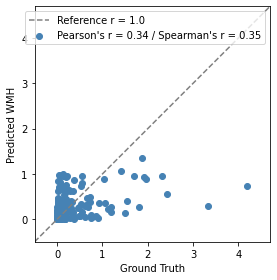

In [34]:
_,_ = predict(model, test_loader)

In [ ]:
net = SFCN()
net.load_state_dict(torch.load('pretrained/230131_sfcn+mae_best'))
net.to(device)
_,_ = predict(net, test_loader)

In [ ]:
dataset = NeckDataset(train_X, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)
_,_ = predict(model, train_loader, 'Training set')